# Text Generation Detection: GPT or Human

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, multiply, SpatialDropout1D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, save_model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
# from langdetect import detect
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from tensorflow.keras.preprocessing.text import Tokenizer  # импортируем токенизатор
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # колбэки

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
train.head()

,q_title,q_id,label,ans_text,line_id
0,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,hu_answer,"Да ничего особенного. :)\nКорпус должен быть, ...",735ba0c5-e6b2-461a-bf5d-b7cb67d42299
1,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,ai_answer,Здравствуйте! Спасибо за интересный вопрос. Дл...,f5eb55c6-2785-4ddc-8f97-30021fd75d68
2,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,ai_answer,"To load a reusable UITableViewCell from a Nib,...",bfd3d85e-6981-423d-a138-7580530a1f85
3,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,hu_answer,"Actually, since you are building the cell in I...",b823bb82-4b05-41ec-b226-7bd0aef29711
4,How can I change UIButton title color?,ffeccbf1-eff2-42b2-a472-f2a8c70b7dbd,hu_answer,You can use -[UIButton setTitleColor:forState:...,4816a574-6bbf-4658-b37b-39d05c29dfca


In [3]:
# удаляем не испульзуемые колонки
del train['q_id']
del train['line_id']

In [4]:
all_text = train['q_title'].to_list() + train['ans_text'].to_list()  # собираем все тексты для токенизатора

In [5]:
max_words = 61000  # размер словаря
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_text)

In [6]:
tok = tokenizer.to_json()

with open('/content/drive/MyDrive/Базы/tokenizer.json', 'w') as json_file:
    json_file.write(tok)

In [7]:
# выводим словарь частотности
# print(tokenizer.word_index)

In [8]:
#  преобразуем текст в числа
ans_text = tokenizer.texts_to_sequences(train['ans_text'])
# q_title = tokenizer.texts_to_sequences(train['q_title'])

In [9]:
# заменяем колонки
train['ans_text'] = ans_text
train

,q_title,label,ans_text
0,"Какие комплектующие должны быть в компьютере, ...",hu_answer,"[331, 751, 16653, 13673, 799, 82, 330, 405, 22..."
1,"Какие комплектующие должны быть в компьютере, ...",ai_answer,"[576, 395, 74, 475, 144, 40, 147, 101, 1736, 1..."
2,Loading a Reusable UITableViewCell from a Nib,ai_answer,"[3, 628, 5, 7833, 3115, 36, 5, 5357, 11, 76, 3..."
3,Loading a Reusable UITableViewCell from a Nib,hu_answer,"[480, 464, 11, 34, 1591, 2, 816, 10, 768, 2041..."
4,How can I change UIButton title color?,hu_answer,"[11, 17, 33, 2542, 13680, 5185, 3, 73, 16, 83,..."
...,...,...,...
4814,Windows batch: call more than one command in a...,ai_answer,"[169, 723, 3, 396, 97, 168, 60, 99, 10, 5, 12,..."
4815,Windows batch: call more than one command in a...,hu_answer,"[52, 9, 2361, 12, 1760, 1431, 55, 15, 578, 240..."
4816,I can't install pyaudio on Windows? How to sol...,hu_answer,"[2, 363, 46, 60928, 9, 791, 868, 7, 23, 123, 1..."
4817,I can't install pyaudio on Windows? How to sol...,ai_answer,"[18, 942, 84, 11, 34, 882, 2, 1021, 772, 88, 1..."


In [10]:
# создаём колонку с метками
train['label_ohe'] = 0
train.loc[train['label']=="hu_answer", "label_ohe"] = 1
train = train.drop('label', axis = 1)
train = train.drop('q_title', axis = 1)

In [11]:
# функция для подсчёта метрики F1
def compute_metric(pred, y):
    score = f1_score(y, pred)
    return score

In [12]:
train.head()

,ans_text,label_ohe
0,"[331, 751, 16653, 13673, 799, 82, 330, 405, 22...",1
1,"[576, 395, 74, 475, 144, 40, 147, 101, 1736, 1...",0
2,"[3, 628, 5, 7833, 3115, 36, 5, 5357, 11, 76, 3...",0
3,"[480, 464, 11, 34, 1591, 2, 816, 10, 768, 2041...",1
4,"[11, 17, 33, 2542, 13680, 5185, 3, 73, 16, 83,...",1


In [13]:
#находим максимальную последовательность в ответах
len_vector = 0
for i in train['ans_text']:
    if len_vector <= len(i): len_vector=len(i)

print(len_vector)

3569


### Embedding

In [14]:
x_train = pad_sequences(ans_text)  # добиваем 0 последователньости до максимального вектора в ответах

In [15]:
x_train

array([[    0,     0,     0, ...,    22,   500,  1506],
       [    0,     0,     0, ...,  3536,  1828,   139],
       [    0,     0,     0, ...,    25,   584,   162],
       ...,
       [    0,     0,     0, ...,  3418, 12896,  5039],
       [    0,     0,     0, ...,     3,    29,   563],
       [    0,     0,     0, ...,   635,    12,    11]])

In [16]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, train['label_ohe'], test_size=0.15, shuffle=True)  # делим на обучающую и валидационную выборки

In [17]:
# колбэки
# earlystop_callb = EarlyStopping(monitor='val_accuracy',   # колбэк на остановку
#                                 patience=25,
#                                 )

# checkpoint_callb = ModelCheckpoint(filepath='/content/drive/MyDrive/Базы/хак2.h5',   # колбэк на сохранение лучшей модели
#                                    monitor='val_accuracy',
#                                    save_best_only=True)

# reducelr_callb = ReduceLROnPlateau(monitor ='val_accuracy',    # колбэк на уменьшения lr
#                                    factor=0.1,
#                                    patience=20,
#                                    verbose=1)

In [18]:
#Создаём сеть с Embedding слоем
model03 = Sequential()
model03.add(Embedding(max_words, 20, input_length=len_vector, mask_zero=True))
model03.add(SpatialDropout1D(0.2))
model03.add(Flatten())
# model03.add(BatchNormalization())
model03.add(Dense(200, activation="relu"))
model03.add(Dense(1, activation='sigmoid'))

model03.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3569, 20)          1220000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 3569, 20)         0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 71380)             0         
                                                                 
 dense (Dense)               (None, 200)               14276200  
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 15,496,401
Trainable params: 15,496,401
Non-trainable params: 0
____________________________________________

In [19]:
x_tr

array([[    0,     0,     0, ...,     6,  6867, 13943],
       [    0,     0,     0, ...,  2448, 40481, 40482],
       [    0,     0,     0, ...,   544,    52,    88],
       ...,
       [    0,     0,     0, ...,  8153,     4,  8460],
       [    0,     0,     0, ...,   138,   752,  6339],
       [    0,     0,     0, ...,   351,    16,   348]])

In [20]:
y_tr

196     0
1595    1
16      0
2832    1
4774    0
       ..
3116    0
2364    0
2588    0
1295    1
2542    0
Name: label_ohe, Length: 4096, dtype: int64

In [21]:
#Обучаем сеть на xTrain
history = model03.fit(x_tr,
                      y_tr,
                      epochs=25,
                      batch_size=128,
                      validation_data=(x_val, y_val)
                      )

Epoch 1/25
32/32 [==============================] - 8s 208ms/step - loss: 0.8791 - accuracy: 0.5374 - val_loss: 0.6417 - val_accuracy: 0.6985
Epoch 2/25
32/32 [==============================] - 7s 220ms/step - loss: 0.5566 - accuracy: 0.7712 - val_loss: 0.4971 - val_accuracy: 0.7953
Epoch 3/25
32/32 [==============================] - 7s 229ms/step - loss: 0.3412 - accuracy: 0.8845 - val_loss: 0.3371 - val_accuracy: 0.8645
Epoch 4/25
32/32 [==============================] - 7s 219ms/step - loss: 0.1652 - accuracy: 0.9578 - val_loss: 0.2489 - val_accuracy: 0.9129
Epoch 5/25
32/32 [==============================] - 7s 215ms/step - loss: 0.0781 - accuracy: 0.9834 - val_loss: 0.2068 - val_accuracy: 0.9364
Epoch 6/25
32/32 [==============================] - 7s 212ms/step - loss: 0.0409 - accuracy: 0.9941 - val_loss: 0.1915 - val_accuracy: 0.9295
Epoch 7/25
32/32 [==============================] - 7s 210ms/step - loss: 0.0221 - accuracy: 0.9976 - val_loss: 0.1761 - val_accuracy: 0.9405
Epoch 

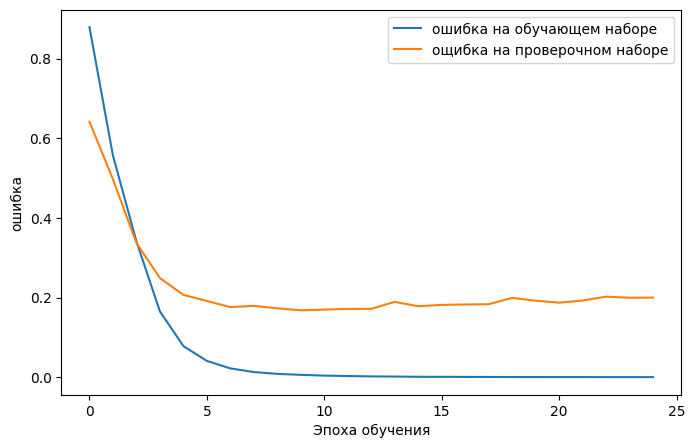

In [22]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'],
         label='ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='ощибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('ошибка')
plt.legend()
plt.show()

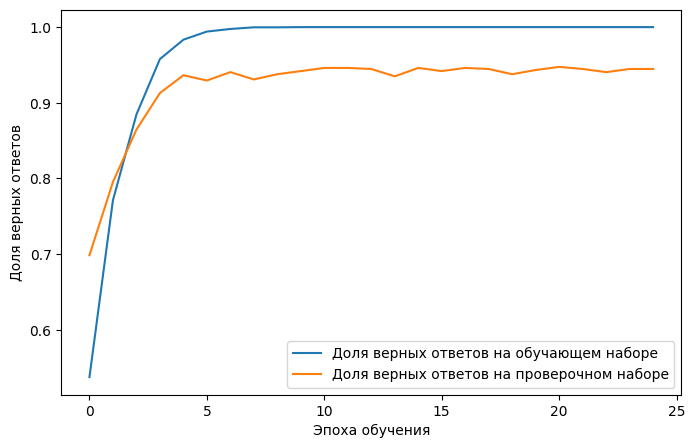

In [23]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [24]:
pre = model03.predict(x_val)  # предиктим

23/23 [==============================] - 0s 12ms/step


In [25]:
li_pre = [int(round(i[0], 0)) for i in pre]  # переводим вероятность формата float в тип int и добавляем в список

In [26]:
compute_metric(li_pre, y_val)  # выводим метрику F1

0.9388379204892967

In [27]:
model03 = model03.save('/content/drive/MyDrive/Базы/хак2_emb.h5')  # загр модель

In [28]:
model03 = load_model('/content/drive/MyDrive/Базы/хак2_emb.h5')  # загр модель

### BoW

а теперь попробуем без учёта порядка слов

In [29]:
x_train = tokenizer.sequences_to_matrix(ans_text)  # преобразуем в BoW

In [30]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, train['label_ohe'], test_size=0.5, shuffle=True)  # делим на обучающую и валидационную выборки

In [31]:
# колбэки
# earlystop_callb = EarlyStopping(monitor='val_accuracy',   # колбэк на остановку
#                                 patience=25,
#                                 )

checkpoint_callb = ModelCheckpoint(filepath='/content/drive/MyDrive/Базы/хак2_bow.h5',   # колбэк на сохранение лучшей модели
                                   monitor='val_accuracy',
                                   save_best_only=True)

# reducelr_callb = ReduceLROnPlateau(monitor ='val_accuracy',    # колбэк на уменьшения lr
#                                    factor=0.1,
#                                    patience=20,
#                                    verbose=1)

In [32]:
#Создаём сеть с Embedding слоем
model03 = Sequential()

model03.add(Dense(128, input_shape=(max_words,), activation="relu"))
# model03.add(Dropout(0.25))
# model03.add(BatchNormalization())
model03.add(Dense(1, activation='sigmoid'))

model03.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model03.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               7808128   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7,808,257
Trainable params: 7,808,257
Non-trainable params: 0
_________________________________________________________________


In [33]:
# model03.compile(optimizer=Adam(0.0001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [34]:
#Обучаем сеть на xTrain
history = model03.fit(x_tr,
                      y_tr,
                      epochs=15,
                      batch_size=128,
                      validation_data=(x_val, y_val),
                      callbacks=[checkpoint_callb]
                      )

Epoch 1/15
19/19 [==============================] - 4s 146ms/step - loss: 0.4883 - accuracy: 0.7970 - val_loss: 0.3041 - val_accuracy: 0.9220
Epoch 2/15
19/19 [==============================] - 2s 123ms/step - loss: 0.1301 - accuracy: 0.9863 - val_loss: 0.2046 - val_accuracy: 0.9336
Epoch 3/15
19/19 [==============================] - 2s 123ms/step - loss: 0.0515 - accuracy: 0.9975 - val_loss: 0.1791 - val_accuracy: 0.9365
Epoch 4/15
19/19 [==============================] - 2s 121ms/step - loss: 0.0262 - accuracy: 0.9992 - val_loss: 0.1684 - val_accuracy: 0.9390
Epoch 5/15
19/19 [==============================] - 2s 121ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.1640 - val_accuracy: 0.9402
Epoch 6/15
19/19 [==============================] - 2s 113ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.1618 - val_accuracy: 0.9398
Epoch 7/15
19/19 [==============================] - 2s 112ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.1614 - val_accuracy: 0.9398
Epoch 

In [35]:
model03.evaluate(x_val, y_val)

76/76 [==============================] - 1s 8ms/step - loss: 0.1629 - accuracy: 0.9407


[0.16288436949253082, 0.9406638741493225]

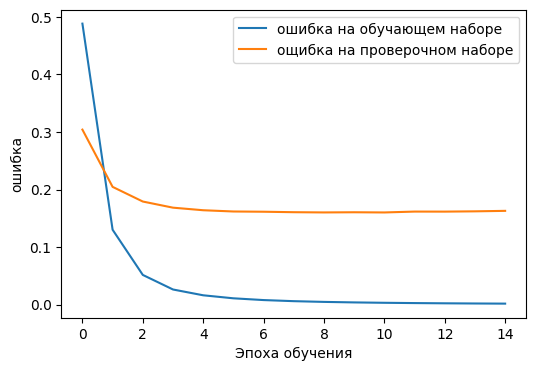

In [36]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],
         label='ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='ощибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('ошибка')
plt.legend()
plt.show()

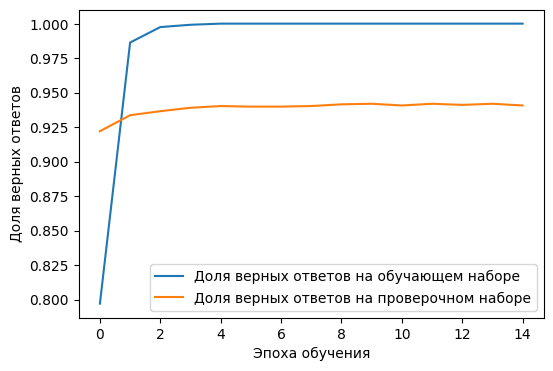

In [37]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [38]:
pre = model03.predict(x_train)  # предиктим

151/151 [==============================] - 1s 8ms/step


In [39]:
li_pre = [int(round(i[0], 0)) for i in pre]  # переводим вероятность формата float в тип int и добавляем в список

In [40]:
compute_metric(li_pre, train['label_ohe'])  # выводим метрику F1

0.9698375870069607

# сабмит

In [41]:
%%writefile m.py
import pathlib
import pandas as pd
import numpy as np
import keras as K

MODEL_FILE = pathlib.Path(__file__).parent.joinpath("хак2.h5")
token_file = pathlib.Path(__file__).parent.joinpath("tokenizer.json")

# функция предиктит ответы
def train_and_make_predictions(X_test):
    model = K.models.load_model(MODEL_FILE)
    y_pred = model.predict(X_test)
    y_pred = [int(round(i[0], 0)) for i in y_pred]
    return y_pred

#  преобработка данных и предсказание
if __name__ == "__main__":
    # чтение файла тест
    df_test = pd.read_csv("data/test.csv")

    # преобразование колонки ответов в массив
    ans_test = df_test["ans_text"].values

    with open(token_file, 'r') as f:
      tokenizer_config = f.read()
      tokenizer = K.preprocessing.text.tokenizer_from_json(tokenizer_config)

    ans_test = tokenizer.texts_to_sequences(ans_test)

    x_test = tokenizer.sequences_to_matrix(ans_test)

    # предсказание модели
    y_pred = train_and_make_predictions(x_test)

    df_test["label"] = y_pred
    df_test["label"] = df_test["label"].map({1: 'hu_answer', 0: 'ai_answer'})
    df_test[["line_id", "label"]].to_csv("data/submission.csv", sep=",", index=False)

Overwriting m.py
